<a href="https://colab.research.google.com/github/averrise/averrise.github.io/blob/master/_posts/fastai%26pytorch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install -Uqq fastai

In [45]:

!pip install -Uqq fastai
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [46]:
from fastai.vision.all import*
path = untar_data(URLs.PASCAL_2007)

In [47]:
df = pd.read_csv(path/'train.csv')
df

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
...,...,...,...
5006,009954.jpg,horse person,True
5007,009955.jpg,boat,True
5008,009958.jpg,person bicycle,True
5009,009959.jpg,car,False


In [48]:
dblock = DataBlock()

데이터셋의 생성 검증으로 시작한 다음에 datablock 구축

In [49]:
dsets = dblock.datasets(df)

dblock으로 datasets 객체 생성 가능

In [50]:
dsets.train[0]

(fname       008690.jpg
 labels          person
 is_valid         False
 Name: 4355, dtype: object,
 fname       008690.jpg
 labels          person
 is_valid         False
 Name: 4355, dtype: object)

같은 열을 두번 반환하는 이유는 기본적으로 데이터블록에는 입력과 타깃 두 요소가 포함된다고 가정하기 때문이다.

In [51]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r : r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('008042.jpg', 'sofa person bottle')

In [52]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/009882.jpg'),
 ['tvmonitor', 'person'])

get_x 와 get_y라는 함수로 입력과 타깃을 분리 시킴

In [53]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]))

CategoryBlock은 단일 정수만을 반환 MulticategoryBlock을 사용하면 이 문제를 해결 가능

In [54]:
idxs = torch.where(dsets.train[0][1]== 1.)[0]
dsets.train.vocab[idxs]

(#1) ['motorbike']

torch.where(dsets.train[0][1]== 1.)[0]은 텐서중 1이 나온것의 위치를 반환한다

In [55]:
dsets.train[0][1]

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

??vocab

In [56]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

False인 행들을 훈련데이터로 사용 하는 것은 모델을 학습할 때 해당 데이터를 잘 예측하는 능력을 향상 시키기 위함 이다.

In [57]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x=get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

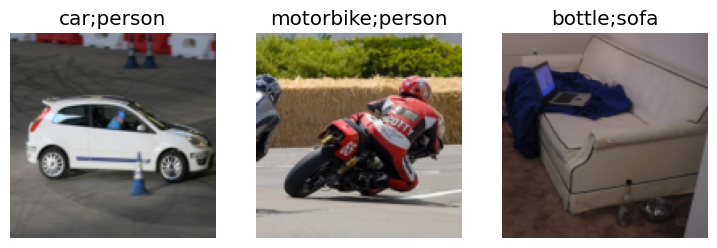

In [58]:
dls.show_batch(nrows = 1, ncols=3)

In [59]:
learn = cnn_learner(dls, resnet18)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
x,y = dls.train.one_batch()
x = x.to('cuda')
y = y.to('cuda')
learn.model = learn.model.to('cuda')
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

x,y,model 전부 gpu서버에 있어야함

In [61]:
activs[0]

TensorImage([ 1.5652e+00,  7.7759e-01,  1.5995e+00, -4.1936e-01, -2.2729e+00, -2.7802e-01,  7.8721e-01,  1.5831e+00,  1.5242e-01,  1.6974e+00, -9.3066e-01,  1.4911e+00,  1.2993e+00, -1.3375e+00,
              4.1914e-04,  3.3157e-01,  2.8073e-01, -1.2196e+00,  8.8582e-01, -7.6412e-01], device='cuda:0', grad_fn=<AliasBackward0>)

In [62]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, 1-inputs, inputs).log().mean()

In [63]:
TensorImage.register_func(torch.nn.functional.binary_cross_entropy_with_logits,TensorImage, TensorMultiCategory )

없어서 함수를 추가

In [64]:

loss_func =torch.nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorImage(1.0445, device='cuda:0', grad_fn=<AliasBackward0>)

In [65]:
def accuracy(inp, targ, axis = -1):
  "'pred' 가 bs*n_classes(배치 크기* 범주 개수)일 때 'targ'로 정확도를 계산합니다"
  pred = inp.argmax(dim = axis)
  return (pred == targ).float().mean()

In [66]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  "'inp'와 'targ'의 크기가 같을 때 정확도를 계산합니다"
  if sigmoid: inp = inp.sigmoid()
  return ((inp>thresh)==targ.bool()).float().mean()

In [67]:
def say_hello(name, say_what='Hello'): return f"{say_what} {name}."
say_hello('jeremy'),say_hello('jeremy','Ahoy!')

('Hello jeremy.', 'Ahoy! jeremy.')

In [68]:
learn = cnn_learner(dls, resnet50, metrics = partial(accuracy_multi, thresh = 0.2))
learn.fine_tune(3, base_lr = 3e-3, freeze_epochs = 4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.936963,0.693862,0.239542,00:19
1,0.820685,0.559279,0.293287,00:18
2,0.599293,0.204974,0.821614,00:17
3,0.359311,0.124016,0.941952,00:15


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.134964,0.117398,0.945857,00:17
1,0.119211,0.105584,0.948048,00:17
2,0.098580,0.102711,0.950737,00:18


In [69]:
learn.metrics = partial(accuracy_multi, thresh = 0.1)
learn.validate()

(#2) [0.10271060466766357,0.9295817017555237]

In [70]:
learn.metrics = partial(accuracy_multi, thresh = 0.99)
learn.validate()

(#2) [0.10271060466766357,0.9435058832168579]

In [71]:
learn.metrics = partial(accuracy_multi, thresh = 0.2)
learn.validate()

(#2) [0.10271060466766357,0.9507369995117188]

In [72]:
preds, targs = learn.get_preds()

In [73]:
accuracy_multi(preds, targs, thresh = 0.2, sigmoid=False)

tensor(0.9507)

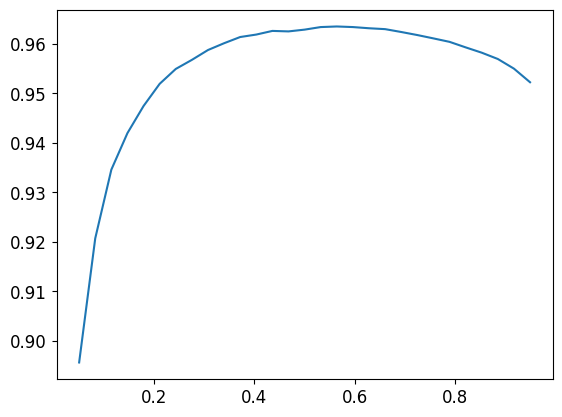

In [74]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh = i, sigmoid = False) for i in xs]
plt.plot(xs, accs)

지금부터 회귀

In [75]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [76]:
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/18.obj'),Path('/root/.fastai/data/biwi_head_pose/19.obj'),Path('/root/.fastai/data/biwi_head_pose/24'),Path('/root/.fastai/data/biwi_head_pose/13.obj'),Path('/root/.fastai/data/biwi_head_pose/08.obj'),Path('/root/.fastai/data/biwi_head_pose/23'),Path('/root/.fastai/data/biwi_head_pose/15'),Path('/root/.fastai/data/biwi_head_pose/io_sample.cpp'),Path('/root/.fastai/data/biwi_head_pose/19'),Path('/root/.fastai/data/biwi_head_pose/05')...]

In [77]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00271_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00071_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00358_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00372_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00271_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00084_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00073_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00155_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00404_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00360_rgb.jpg')...]

In [78]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/24/frame_00071_pose.txt')

In [79]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

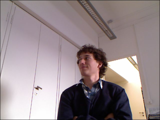

In [80]:
im.to_thumb(160)

In [81]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer = 6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header = 3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1, c2])

In [82]:
get_ctr(img_files[0])

tensor([362.8622, 242.4683])

In [83]:
biwi = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name == '13'),
    batch_tfms = [*aug_transforms(size=(240,320)),
                  Normalize.from_stats(*imagenet_stats)]
)

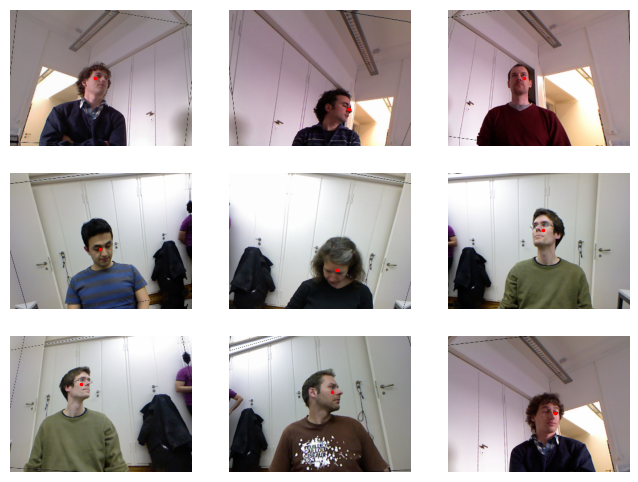

In [84]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n = 9, figsize = (8,6))

In [85]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

64개의 샘플 배치 3개의 rgb

In [87]:
learn = cnn_learner(dls, resnet18, y_range=(-1, 1))

In [88]:
def sigmoid_range(x,lo,hi): return torch.sigmoid(x)*(hi-lo)+lo

In [89]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0012022644514217973)

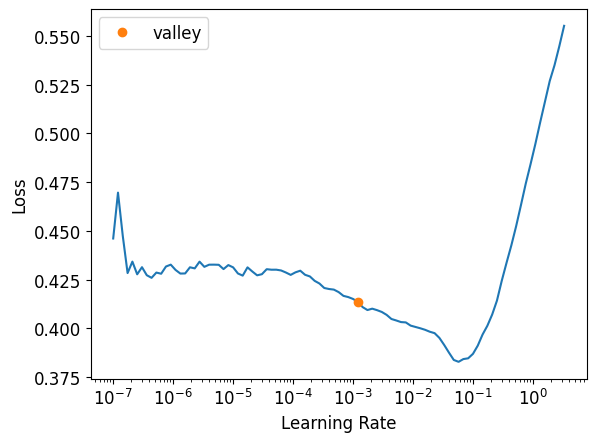

In [90]:
learn.lr_find()

In [91]:
lr = 1e-2
learn.fine_tune(3,lr)

epoch,train_loss,valid_loss,time
0,0.048482,0.032195,01:14


epoch,train_loss,valid_loss,time
0,0.009040,0.002061,01:31
1,0.003165,0.000336,01:32
2,0.001430,0.000098,01:30


In [92]:
math.sqrt(0.0001)

0.01

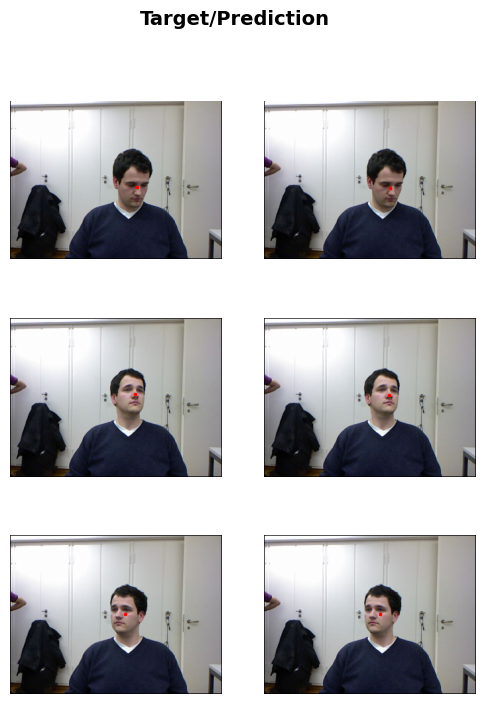

In [93]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))